# Multi Agent Reinforcement Learning

In this tutorial, we will teach you how to train a simple MARL agent, on the Knights, Archers and Zombies environment.

### Dependencies

In [1]:
!pip3 install torchrl==0.7.0
!pip3 install tensordict==0.7.2
!pip3 install pettingzoo
!pip3 install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.3/414.3 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.

### Import Libraries

In [2]:
# Torch
import torch
import torch.nn as nn

# Tensordict modules
from tensordict.nn import set_composite_lp_aggregate, TensorDictModule, TensorDictSequential
from tensordict import  TensorDictBase
from torch import multiprocessing

# Data collection
from torchrl.collectors import SyncDataCollector
from torch.distributions import Categorical
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

#Env
from torchrl.envs import RewardSum, TransformedEnv, PettingZooWrapper, Compose, DoubleToFloat, StepCounter, ParallelEnv, EnvCreator, ExplorationType, set_exploration_type

# Utils
from torchrl.envs.utils import check_env_specs

# Multi-agent network
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal

# Loss
from torchrl.objectives import ClipPPOLoss, ValueEstimators

# Utils
torch.manual_seed(0)
from matplotlib import pyplot as plt
from tqdm import tqdm

/usr/local/lib/python3.11/dist-packages/torchrl/data/replay_buffers/samplers.py:37: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. This is likely due to a discrepancy between your package version and the PyTorch version. Make sure both are compatible. Usually, torchrl majors follow the pytorch majors within a few days around the release. For instance, TorchRL 0.5 requires PyTorch 2.4.0, and TorchRL 0.6 requires PyTorch 2.5.0.
  warnings.warn(EXTENSION_WARNING)


### Load PettingZoo Library and Env

In [3]:
from pettingzoo.butterfly import knights_archers_zombies_v10

base_env = knights_archers_zombies_v10.parallel_env(render_mode="rgb_array")
env = PettingZooWrapper(base_env)


/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

### Set hyperparameters

These are the hyperparameters for the training and the general environment later. We need these to instantiate our neural networks, as well as for the MAPPO loss.

In [4]:
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)

#Parameters for Env
n_parallel_envs = 2  # Number of parallel environments

# Sampling
frames_per_batch = 2_000  # Number of team frames collected per training iteration
total_frames = 200_000

# Training
num_epochs = 5  # Number of optimization steps per training iteration
minibatch_size = 400  # Size of the mini-batches in each optimization step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# PPO
clip_epsilon = 0.2  # clip value for PPO loss
gamma = 0.99  # discount factor
lmbda = 0.9  # lambda for generalised advantage estimation
entropy_eps = 1e-4  # coefficient of the entropy term in the PPO loss

# disable log-prob aggregation
set_composite_lp_aggregate(False).set()

### Define Transforms

RewardSum helps to sum up all the rewards for a particular group of agents. For example, I might have 2 archers and 2 knights, and it becomes very unwieldy to track the rewards for each individual agent. In fact, we might end up reusing a lot of logic, especially for agents of the same type. RewardSum removes this issue by summing the rewards for a specific type of agent.

In [5]:
# Create reward transforms with the correct nested tuple keys
reward_transforms = [
    # For archer agents
    RewardSum(
        in_keys=[("archer", "reward")],  # Use tuple format for nested keys
        out_keys=[("archer", "episode_reward")]
    ),
    # For knight agents
    RewardSum(
        in_keys=[("knight", "reward")],  # Use tuple format for nested keys
        out_keys=[("knight", "episode_reward")]
    )
]

# Apply the transforms
make_env = EnvCreator(lambda: TransformedEnv(
    PettingZooWrapper(knights_archers_zombies_v10.parallel_env(render_mode="rgb_array")),
    Compose(RewardSum(
        in_keys=[("archer", "reward")],  # Use tuple format for nested keys
        out_keys=[("archer", "episode_reward")]
    ),
    # For knight agents
    RewardSum(
        in_keys=[("knight", "reward")],  # Use tuple format for nested keys
        out_keys=[("knight", "episode_reward")]
    ), DoubleToFloat(), StepCounter())
)
)

env = ParallelEnv(n_parallel_envs, make_env, serial_for_single=True)

### Check Environment Specs
- ALWAYS make sure to check your environment. It is the first line of defense to any issues when setting up your environment. If `check_env_specs` fails, you can bet 99% any downstream setting or rollouts will fail too.

In [6]:
print("action_keys:", env.action_keys)
print("reward_keys:", env.reward_keys)
print("done_keys:", env.done_keys)

print("Action Spec:", env.action_spec)
print("Observation Spec:", env.observation_spec)
print("Reward Spec:", env.reward_spec)
print("Done Spec:", env.done_spec)

check_env_specs(env)

action_keys: [('archer', 'action'), ('knight', 'action')]
reward_keys: [('archer', 'reward'), ('knight', 'reward')]
done_keys: ['done', 'terminated', 'truncated', ('archer', 'done'), ('archer', 'terminated'), ('archer', 'truncated'), ('knight', 'done'), ('knight', 'terminated'), ('knight', 'truncated')]
Action Spec: Composite(
    archer: Composite(
        action: Categorical(
            shape=torch.Size([2, 2]),
            space=CategoricalBox(n=6),
            device=cpu,
            dtype=torch.int64,
            domain=discrete),
        device=cpu,
        shape=torch.Size([2, 2])),
    knight: Composite(
        action: Categorical(
            shape=torch.Size([2, 2]),
            space=CategoricalBox(n=6),
            device=cpu,
            dtype=torch.int64,
            domain=discrete),
        device=cpu,
        shape=torch.Size([2, 2])),
    device=cpu,
    shape=torch.Size([2]))
Observation Spec: Composite(
    archer: Composite(
        observation: BoundedContinuous

2025-05-06 05:21:26,285 [torchrl][INFO] check_env_specs succeeded!


### Test env again

We do some rollouts to ensure environment is working fine.

In [7]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print(f"rollout of {n_rollout_steps} steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of 5 steps: TensorDict(
    fields={
        archer: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([2, 5, 2]), device=cpu, dtype=torch.int64, is_shared=False),
                done: Tensor(shape=torch.Size([2, 5, 2, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([2, 5, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([2, 5, 2, 27, 5]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([2, 5, 2, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([2, 5, 2, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([2, 5, 2]),
            device=None,
            is_shared=False),
        done: Tensor(shape=torch.Size([2, 5, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        knight

### Defining the policy

Over here, we implement a simple policy. Do note that we use MultiAgentMLP instead of nn.Linear. This is an abstraction by TorchRL that helps us handle the shapes and many other complexities when building a training pipeline for MARL.

We add a FlattenObs to handle both the multiple batches, additional dimension from ParallelEnv as well as the number of entities in the observation (The agents can see and record relative distance and position about all other agents in their observation)

An astute observation would be that, outside of a few small changes to the code, the structure of the code is exactly that of single-agent RL:

1. Build Environment
1. Test Environment
1. Build Actor Critic
1. Build Loss
1. Train
1. Visualize

This is only possible as TorchRL provides modular code, which allows for the swapping of losses and critics without much disruption to the structure of the code.

### FAQ: Why `for group in [archer, knight]`?

This is because we have different types of agents, which might require a different policy each, due to a different role being played by each type. For example, archers should maximise their distance from the zombies as they have a ranged weapons, but if knights were to follow the same policy, they would be extremely useless.

To prevent this, we do a for loop to assign different policy based on the agent.


In [8]:
n_archers = env.observation_spec["archer", "observation"].shape[1]
n_knights = env.observation_spec["knight", "observation"].shape[1]
n_entities = env.observation_spec["archer", "observation"].shape[2]
n_features = env.observation_spec["archer", "observation"].shape[3]

# Create a flattening module that handles the batched_env+time dimensions
class FlattenObs(nn.Module):
    def forward(self, obs):
        # Convert to float first
        obs = obs.float()

        # Handle different possible shapes
        if len(obs.shape) == 5:  # [batch_env, time, n_agents, n_entities, n_features]
            batch_env, time, n_agents, n_entities, n_features = obs.shape

            # Reshape to merge batch_env and time dimensions
            # This gives [batch_env*time, n_agents, n_entities, n_features]
            obs = obs.reshape(-1, n_agents, n_entities, n_features)

            # Take only the first entity for each agent (agent itself)
            return obs[:, :, 0, :]  # [batch_env*time, n_agents, n_features]

        elif len(obs.shape) == 4:  # [batch, n_agents, n_entities, n_features]
            batch, n_agents, n_entities, n_features = obs.shape
            return obs[:, :, 0, :]  # [batch, n_agents, n_features]

        elif len(obs.shape) == 3:  # [batch, n_entities, n_features]
              batch, n_entities, n_features = obs.shape
              return obs.reshape(batch, n_entities * n_features)

        # Fallback for unexpected shapes
        return obs

# Create policy modules for each agent type
policy_modules = {}
for group in ["archer", "knight"]:
    n_agents = n_archers if group == "archer" else n_knights
    share_parameters_policy = True

    # Create MLP for policy
    policy_mlp = MultiAgentMLP(
        n_agent_inputs=n_features,  # Only using features of the agent itself
        n_agent_outputs=6,  # 6 discrete actions in KAZ
        n_agents=n_agents, # 2 agents per type
        centralised=False, #The agents are decentralised (i.e. Each agent will act from its own observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    )

    # Create sequential module with flattening
    policy_seq = nn.Sequential(FlattenObs(), policy_mlp, nn.Softmax(dim=-1))

    # Wrap in TensorDictModule
    policy_modules[group] = TensorDictModule(
        module=policy_seq,
        in_keys=[(group, "observation")],
        out_keys=[(group, "probs")]
    )


### Create an actor based on the policy

This portion is very similar to single agent RL, and we are just wrapping everything in a ProbabilisticActor class for downstream TorchRL classes to use.

In [9]:
# Create actors for each agent type
policies = {}
for group in ["archer", "knight"]:
    policies[group] = ProbabilisticActor(
        module=policy_modules[group],  # Use the policy module directly
        spec=env.action_spec[group, "action"],
        in_keys=[(group, "probs")],
        out_keys=[(group, "action")],
        distribution_class=Categorical,
        return_log_prob=True,
    )

### Critic

For the critic code, outside of the for loop, there are two important hyperparameters we have added: `share_parameters_critic` and `MAPPO`

For share_parameters, you will need to consider its feasibility in different use cases. There are two places where you can set share_parameters to True.

1. In the policy
1. In the critic

These will have adverse effects depending on what you are training.

**For policy**

Sharing the parameters in the policy will make your code run much faster as different agent policies share the same weights, allowing them to benefit from each other's experiences. However, the caveat is that all agents will share the same behaviour.

**For Critic**

There are recommended scenarios where share_parameters should not be activated:
- Sharing is not recommended when agents have different reward functions, as the critics will need to learn to assign different values to the same state (e.g., in mixed cooperative-competitive settings).
- In decentralized training settings, sharing cannot be performed without modifications to sync up parameters.

### MAPPO vs IPPO

MAPPO and IPPO are just variants of PPO implemented for MARL. They differ in terms of centralised vs decentralised critics, but the code structure remains the same regardless.

Centralised vs Decentralised:

Centralised -> The critic is shared by all different agents -> It takes in the concatenated agent observations as input. Since training is centralised, we can perform the following.

Decentralised -> Each critic is local to each agent, and gives a value to only that agent's actions based on the observations.

In [10]:
# Update critics to handle the new shape too
critics = {}
for group in ["archer", "knight"]:
    n_agents = n_archers if group == "archer" else n_knights
    share_parameters_critic = True
    MAPPO = True

    # Wrap flattener in TensorDictModule
    flatten_obs_module = TensorDictModule(
        FlattenObs(),
        in_keys=[(group, "observation")],
        out_keys=[(group, "flat_observation")],
    )

    # Create critic module
    critic_module = TensorDictModule(
       module = MultiAgentMLP(
           n_agent_inputs=n_features,
           n_agent_outputs= 1,
           n_agents=n_agents,
           centralised=MAPPO, #True for MAPPO, False for IPPO
           share_params=share_parameters_critic,
           device=device,
           activation_class=torch.nn.Tanh,
           depth=2,
           num_cells=256,
       ), in_keys = [(group, "flat_observation")], out_keys = [(group, "state_value")]
    )

    # Combine modules
    critics[group] = TensorDictSequential(
        flatten_obs_module,
        critic_module,
    )

In [11]:
# Simple testing
reset_td = env.reset()

for group in ["archer", "knight"]:
            if group in reset_td:
                print(f"\nTesting {group} policy module...")
                policy_modules[group](reset_td)
                print(f"✓ {group} policy module successful")
                print(f"Output shape: {reset_td[group, 'probs'].shape}")

# Then, test the actors to generate actions
for group in ["archer", "knight"]:
    if group in reset_td:
        print(f"\nTesting {group} actor...")
        policies[group](reset_td)
        print(f"✓ {group} actor successful")
        print(f"Action shape: {reset_td[group, 'action'].shape}")
        print(f"Sample action: {reset_td[group, 'action']}")

for group in ["archer", "knight"]:
    print(f"{group}:")
    print(critics[group](reset_td))


Testing archer policy module...
✓ archer policy module successful
Output shape: torch.Size([2, 2, 6])

Testing knight policy module...
✓ knight policy module successful
Output shape: torch.Size([2, 2, 6])

Testing archer actor...
✓ archer actor successful
Action shape: torch.Size([2, 2])
Sample action: tensor([[5, 5],
        [5, 5]])

Testing knight actor...
✓ knight actor successful
Action shape: torch.Size([2, 2])
Sample action: tensor([[3, 3],
        [3, 3]])
archer:
TensorDict(
    fields={
        archer: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([2, 2]), device=cpu, dtype=torch.int64, is_shared=False),
                action_log_prob: Tensor(shape=torch.Size([2, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([2, 2, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([2, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),


### Data Collector

In [12]:
# Convert the policy dictionary to a sequential policy for the collector

# If you're using the actors dictionary as your policy:
agents_policy = TensorDictSequential(*policies.values())

# Or if you have a separate policies dictionary:
# agents_policy = TensorDictSequential(*policies.values())

# Create the collector with the sequential policy
collector = SyncDataCollector(
    env,
    agents_policy,
    device=device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

In [13]:
env.rollout(5, policy=agents_policy)


TensorDict(
    fields={
        archer: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([2, 5, 2]), device=cpu, dtype=torch.int64, is_shared=False),
                action_log_prob: Tensor(shape=torch.Size([2, 5, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([2, 5, 2, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                episode_reward: Tensor(shape=torch.Size([2, 5, 2, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                observation: Tensor(shape=torch.Size([2, 5, 2, 27, 5]), device=cpu, dtype=torch.float32, is_shared=False),
                probs: Tensor(shape=torch.Size([2, 5, 2, 6]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([2, 5, 2, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([2, 5, 2, 1]), device=cpu, dtype=torch.bool, is_shared=False)},


### Replay Buffer

In [14]:
# Define agent groups manually
groups = ["archer", "knight"]

# Create separate replay buffers for each group
replay_buffers = {}
for group in groups: 
    replay_buffers[group] = ReplayBuffer(
        storage=LazyTensorStorage(
            frames_per_batch, device=device
        ),
        sampler=SamplerWithoutReplacement(),
        batch_size=minibatch_size,
    )


### Training Loss

Instead of an advantage module, we use a different way of implementing advantage here but it calculates the advantage as well.

In [15]:
from torchrl.objectives import ClipPPOLoss, ValueEstimators

# Create loss modules for each agent type in a dictionary
losses = {}
for group in ["archer", "knight"]:
    # Create the loss module
    loss_module = ClipPPOLoss(
        actor_network=policies[group],
        critic_network=critics[group],
        clip_epsilon=clip_epsilon,
        entropy_coef=entropy_eps,
        normalize_advantage=False
    )

    # Set the appropriate keys
    loss_module.set_keys(
        reward=(group, "reward"),
        action=(group, "action"),
        value=(group, "state_value"),
        done=(group, "done"),
        terminated=(group, "terminated")
    )

    # Create GAE value estimator
    loss_module.make_value_estimator(ValueEstimators.GAE, gamma=gamma, lmbda=lmbda)

    # Add to dictionary
    losses[group] = loss_module

# Create optimizers for each group
optimizers = {}
for group, loss in losses.items():
    # Unlike DDPG, PPO typically uses a single optimizer for both actor and critic
    # But we can follow a similar pattern with a dictionary
    params = list(policies[group].parameters()) + list(critics[group].parameters())
    optimizers[group] = torch.optim.Adam(params, lr=lr)

# PPO doesn't typically use target networks, but if you need similar functionality:
# target_updaters = {
#     group: SomeUpdater(loss) for group, loss in losses.items()
# }

In [16]:
env.reset()

TensorDict(
    fields={
        archer: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([2, 2, 1]), device=cpu, dtype=torch.bool, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([2, 2, 1]), device=cpu, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([2, 2, 27, 5]), device=cpu, dtype=torch.float32, is_shared=True),
                terminated: Tensor(shape=torch.Size([2, 2, 1]), device=cpu, dtype=torch.bool, is_shared=True),
                truncated: Tensor(shape=torch.Size([2, 2, 1]), device=cpu, dtype=torch.bool, is_shared=True)},
            batch_size=torch.Size([2, 2]),
            device=cpu,
            is_shared=False),
        done: Tensor(shape=torch.Size([2, 1]), device=cpu, dtype=torch.bool, is_shared=True),
        knight: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([2, 2, 1]), device=cpu, dtype=torch.bool, is_shared=True),
                e

### Training Code

Everything here is similar to a single agent environment, but we take care of the different agent types by using the correct group's replay buffer and policies, depending on which agent is the current agent.

In [17]:
from torchrl.objectives import ClipPPOLoss, ValueEstimators
import copy
from tqdm import tqdm

# Define agent groups manually
groups = ["archer", "knight"]

def process_batch(batch: TensorDictBase) -> TensorDictBase:
    """
    Expand done and terminated keys for each group to match reward shape.
    """
    for group in groups: 
        keys = list(batch.keys(True, True))
        group_shape = batch.get_item_shape(group)
        nested_done_key = ("next", group, "done")
        nested_terminated_key = ("next", group, "terminated")
        if nested_done_key not in keys:
            batch.set(
                nested_done_key,
                batch.get(("next", "done")).unsqueeze(-1).expand((*group_shape, 1)),
            )
        if nested_terminated_key not in keys:
            batch.set(
                nested_terminated_key,
                batch.get(("next", "terminated"))
                .unsqueeze(-1)
                .expand((*group_shape, 1)),
            )
    return batch

# Training loop
pbar = tqdm(
    total=total_frames,
    desc=", ".join([f"episode_reward_mean_{group} = 0" for group in groups])  # Changed
)
episode_reward_mean_map = {group: [] for group in groups}  # Changed
total_frames_so_far = 0  # Added to track progress

# Training/collection iterations
for iteration, batch in enumerate(collector):
    batch = process_batch(batch)  # Expand done keys if needed

    # Calculate total frames in this batch
    current_batch_size = batch.numel()
    total_frames_so_far += current_batch_size  # Track total frames

    # Process each group
    for group in groups:
        # Extract data for this group only
        group_batch = batch.exclude(
            *[
                key
                for _group in groups  # Changed from env.group_map.keys()
                if _group != group
                for key in [_group, ("next", _group)]
            ]
        )

        # Reshape to flatten batch dimensions
        group_batch = group_batch.reshape(-1)

        # Add to this group's replay buffer
        replay_buffers[group].extend(group_batch)

        # PPO training epochs (multiple passes over the same data)
        for _ in range(num_epochs):
            # Iterate through all minibatches in the buffer once
            for subdata in replay_buffers[group]:
                # Compute loss
                loss_vals = losses[group](subdata)

                # Compute total loss
                loss_value = (
                    loss_vals["loss_objective"] +
                    loss_vals["loss_critic"] +
                    loss_vals["loss_entropy"]
                )

                # Backprop and optimize
                optimizers[group].zero_grad()
                loss_value.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(
                    losses[group].parameters(), max_grad_norm
                )

                optimizers[group].step()

    # Update collector policy with new weights
    collector.update_policy_weights_()

    # Logging with error handling
    for group in groups:  
        done_mask = batch.get(("next", group, "done"))

        # Check if any episodes finished
        if done_mask.any():
            episode_reward_mean = (
                batch.get(("next", group, "episode_reward"))[done_mask]
                .mean()
                .item()
            )
        else:
            # No episodes finished, use previous value or 0
            episode_reward_mean = (
                episode_reward_mean_map[group][-1] if episode_reward_mean_map[group] else 0.0
            )

        episode_reward_mean_map[group].append(episode_reward_mean)

    # Update description with step count
    pbar.set_description(
        f"Steps: {total_frames_so_far}, " +
        ", ".join([
            f"{group}: {episode_reward_mean_map[group][-1]:.2f}"
            for group in groups
        ]),
        refresh=False
    )

    # Update progress bar with total frames processed in this batch
    pbar.update(current_batch_size)


Steps: 200000, archer: 1.60, knight: 0.00: 100%|██████████| 200000/200000 [33:39<00:00, 93.96it/s]

### Visualization

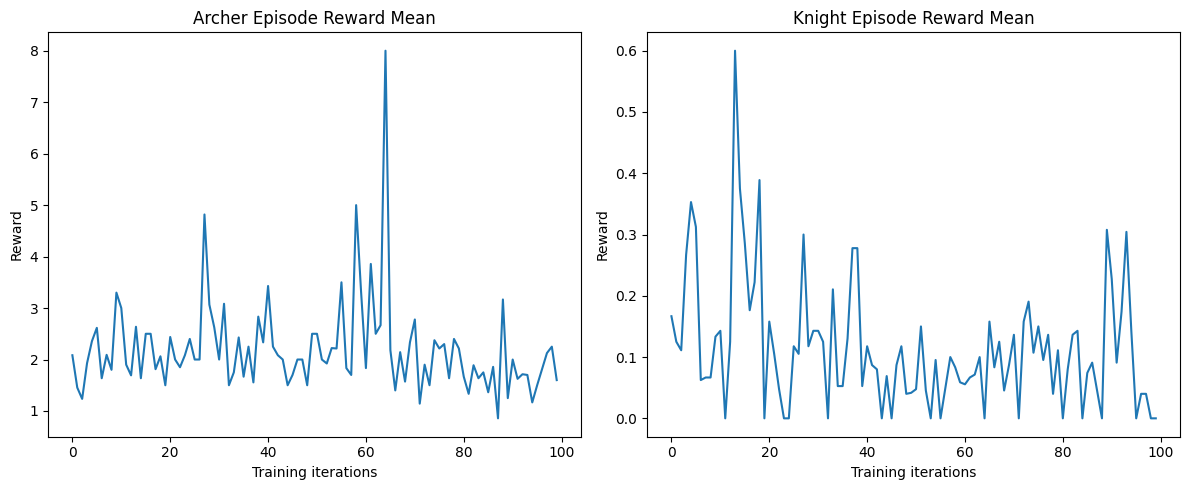

In [18]:

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot archer rewards on the first subplot
axes[0].plot(episode_reward_mean_map["archer"])
axes[0].set_xlabel("Training iterations")
axes[0].set_ylabel("Reward")
axes[0].set_title("Archer Episode Reward Mean")

# Plot knight rewards on the second subplot
axes[1].plot(episode_reward_mean_map["knight"])
axes[1].set_xlabel("Training iterations")
axes[1].set_ylabel("Reward")
axes[1].set_title("Knight Episode Reward Mean")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

/usr/local/lib/python3.11/dist-packages/torchrl/envs/libs/pettingzoo.py:284: UserWarning: PettingZoo in TorchRL is tested using version == 1.24.3 , If you are using a different version and are experiencing compatibility issues,please raise an issue in the TorchRL github.
  warnings.warn(


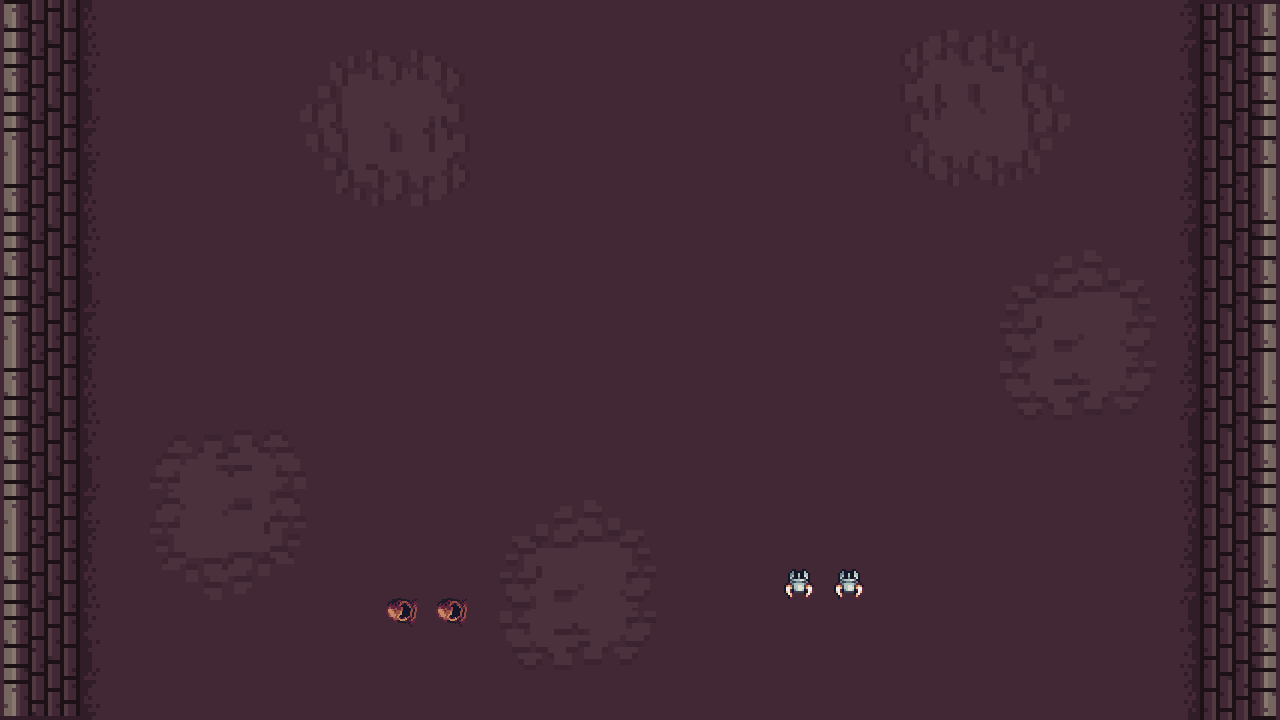

In [20]:
newEnv = ParallelEnv(1, make_env, serial_for_single=True) # To circumvent issue of shape mismatches
newEnv.rollout(max_steps = 1000)

def rendering_callback(env, td):
    env.frames.append(Image.fromarray(env.render()[0]))

newEnv.frames = []
with set_exploration_type(ExplorationType.DETERMINISTIC):
   newEnv.rollout(
       max_steps=1000,
       policy=agents_policy,
       callback=rendering_callback,
   )
newEnv.frames[0].save( #Creates a gif of the results and renders it here
    "test.gif",
    save_all=True,
    append_images=newEnv.frames[1:],
   duration=3,
   loop=0,
)

from IPython.display import Image
Image(open("test.gif", "rb").read())